In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, Input, Layer, MaxPooling2D, Conv2D, Reshape
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.optimizers import Adam

import tensorflow as tf
import numpy as np
import scipy.stats as st
from visualization_functions import *
import itertools
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import sys
import argparse
import os
import glob 

# visualize saliency
from vis.visualization import visualize_saliency, visualize_activation
from vis.utils import utils
from keras import activations

import matplotlib
import matplotlib.pyplot as plt

import dcor

# Simulating Synthetic Images
The training images of two groups are simulated. Each image contains 4 Gaussian distribution density functions. Let the 4 standard deviations be

|  $\sigma_A$ | $\sigma_B$  |

|  $\sigma_B$ | $\sigma_A$  |

The 4 Gaussians are constructed such that

1. height of the two diagonal Gaussians $\sigma_A$ is linked to a factor of interest $mf$ (e.g. true effect between two classes)
2. height of the two off-diagonal Gaussians $\sigma_B$ is linked to two different confounding factors $cf$.

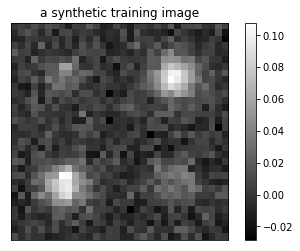

In [2]:
## Simulate Data
np.random.seed(1)

N = 512 # number of subjects in a group
labels = np.zeros((N*2,))
labels[N:] = 1

# 2 confounding effects between 2 groups
cf = np.zeros((N*2,))
cf[:N] = np.random.uniform(1,4,size=N)
cf[N:] = np.random.uniform(3,6,size=N)

# 2 major effects between 2 groups
mf = np.zeros((N*2,))
mf[:N] = np.random.uniform(1,4,size=N)
mf[N:] = np.random.uniform(3,6,size=N)

# simulate images
x = np.zeros((N*2,32,32,1))
y = np.zeros((N*2,))
y[N:] = 1
for i in range(N*2):
    x[i,:16,:16,0] = gkern(kernlen=16, nsig=5)*mf[i]
    x[i,16:,:16,0] = gkern(kernlen=16, nsig=5)*cf[i]
    x[i,:16,16:,0] = gkern(kernlen=16, nsig=5)*cf[i]
    x[i,16:,16:,0] = gkern(kernlen=16, nsig=5)*mf[i]
    x[i] = x[i] + np.random.normal(0,0.01,size=(32,32,1))

plt.imshow(x[1,:,:,0],cmap='gray')
plt.colorbar()
plt.title("a synthetic training image");
plt.xticks(np.arange(0), ())
plt.yticks(np.arange(0), ())
plt.savefig('synthetic_sample.jpg', format='jpg', dpi=300)

# Training BR-Net

In [3]:
# adversial loss for squared correlation 
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym)))) + 1e-5
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return K.square(r)

# adversial loss for mse
def inv_mse(y_true, y_pred):
    mse_value = K.sum(K.square(y_true-y_pred))

    return -mse_value

In [4]:
class GAN():
    
    def __init__(self):

        optimizer = Adam(0.0002)
        optimizer_distiller = Adam(0.0002)
        optimizer_regressor = Adam(0.0002)

        # Build and compile the bias predictor
        self.regressor = self.build_regressor()
        self.regressor.compile(loss='mse', optimizer=optimizer_regressor)

        # Build a naive feature encoder
        input_image = Input(shape=(32,32,1), name='input_image')
        
        feature_dense_enc = Conv2D(2, activation='tanh', kernel_size=(3,3),padding='valid')(input_image)
        feature_dense_enc = MaxPooling2D(pool_size=(2,2))(feature_dense_enc)
        feature_dense_enc = Conv2D(4, activation='tanh', kernel_size=(3,3),padding='valid')(feature_dense_enc)
        feature_dense_enc = MaxPooling2D(pool_size=(2,2))(feature_dense_enc)
        feature_dense_enc = Conv2D(8, activation='tanh', kernel_size=(3,3),padding='valid')(feature_dense_enc)
        feature_dense_enc = MaxPooling2D(pool_size=(2,2))(feature_dense_enc)
        feature_dense_enc = Flatten()(feature_dense_enc)
        self.encoder = Model(input_image, feature_dense_enc)

        # For the distillation model (bias predictor) we will only train the encoder
        self.regressor.trainable = False
        cf = self.regressor(feature_dense_enc)
        self.distiller = Model(input_image, cf)
        
        # set an adversial loss
        self.distiller.compile(loss=correlation_coefficient_loss, optimizer=optimizer_distiller)
        #self.distiller.compile(loss=inv_mse, optimizer=optimizer_distiller)
        
        # Build and Compile the classifer  
        input_feature_clf = Input(shape=(32,), name='input_feature_dense')
        feature_clf = Dense(16, activation='tanh')(input_feature_clf)
        prediction_score = Dense(1, name='prediction_score')(feature_clf)
        self.classifier = Model(input_feature_clf, prediction_score)

        # Build the entire workflow
        prediction_score_workflow = self.classifier(feature_dense_enc)
        label_workflow = Activation('sigmoid', name='r_mean')(prediction_score_workflow)
        self.workflow = Model(input_image, label_workflow)
        self.workflow.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

    def build_regressor(self):
        inputs_x = Input(shape=(32,))
        feature = Dense(16, activation='tanh')(inputs_x)
        cf = Dense(1)(feature)

        return Model(inputs_x, cf)

    def train_cf(self, epochs, training, batch_size=96, fold=0):
        [train_data, train_dx, train_cf] = training
        
        dc = np.zeros((int(epochs/10)+1,))
        feature = np.zeros((int(epochs/10)+1,int(train_data.shape[0]/2),32))
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Disstiller
            # ---------------------

            # Select a random batch of images from the ctrl group
            # Only back-progate adversial loss for the ctrl group
            idx_perm = np.random.permutation(int(train_data.shape[0]/2))
            ctrl_idx = idx_perm[:int(batch_size)*2]
            
            # Select a random batch for training feature encoder and classifier
            idx_perm = np.random.permutation(int(train_data.shape[0]/2))
            idx = idx_perm[:int(batch_size/2)]
            idx = np.concatenate((idx,idx+int(train_data.shape[0]/2)))
            
            training_feature_batch = train_data[idx]
            dx_batch = train_dx[idx]
            cf_batch = train_cf[idx]

            training_feature_ctrl_batch = train_data[ctrl_idx]
            cf_ctrl_batch = train_cf[ctrl_idx]
            
            # ---------------------
            #  Train regressor (bias predictor)
            # ---------------------

            encoded_feature_ctrl_batch = self.encoder.predict(training_feature_ctrl_batch)
            r_loss = self.regressor.train_on_batch(encoded_feature_ctrl_batch, cf_ctrl_batch)

            # ---------------------
            #  Train Encoder & Classifier
            # ---------------------
            
            g_loss = self.distiller.train_on_batch(training_feature_ctrl_batch, cf_ctrl_batch)
            c_loss = self.workflow.train_on_batch(training_feature_batch, dx_batch)
            
            # Plot the training progress
            if epoch % 10 == 0:
                # analyze distance correlation and learned features for CTRL group
                feature[int(epoch/10)] = self.encoder.predict(train_data[train_dx == 0],  batch_size = batch_size)  
                dc[int(epoch/10)] = dcor.u_distance_correlation_sqr(feature[int(epoch/10)], train_cf[train_dx == 0])
            if epoch % 1000 == 0:
                print ("%d [Acc: %f,  \dc: %f]" % (epoch, c_loss[1], dc[int(epoch/10)]))
                
        pred = self.workflow.predict(train_data)
        return dc, feature, pred

In [5]:
gan_cf = GAN()
dc_cf, feature_cf, pred_cf = gan_cf.train_cf(epochs=15001, training=[x, y, cf])

/Users/wuzhejun/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [Acc: 0.500000,  \dc: 0.455031]
1000 [Acc: 0.916667,  \dc: 0.550558]
2000 [Acc: 0.958333,  \dc: 0.454170]
3000 [Acc: 0.947917,  \dc: 0.335209]
4000 [Acc: 0.885417,  \dc: 0.621896]
5000 [Acc: 0.937500,  \dc: 0.212560]
6000 [Acc: 0.947917,  \dc: 0.192306]
7000 [Acc: 0.916667,  \dc: 0.214697]
8000 [Acc: 0.843750,  \dc: 0.081023]
9000 [Acc: 0.875000,  \dc: 0.068492]
10000 [Acc: 0.947917,  \dc: 0.169154]
11000 [Acc: 0.854167,  \dc: 0.186467]
12000 [Acc: 0.895833,  \dc: 0.060341]
13000 [Acc: 0.927083,  \dc: 0.076811]
14000 [Acc: 0.833333,  \dc: 0.107840]
15000 [Acc: 0.906250,  \dc: 0.019964]


# Visualizing the Association between Features and Confounder

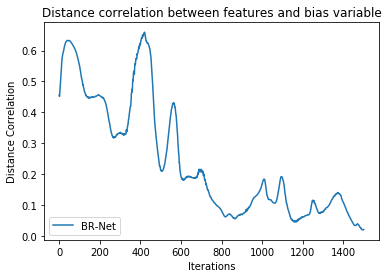

In [6]:
plt.plot(dc_cf,label='BR-Net')
plt.xlabel('Iterations')
plt.ylabel('Distance Correlation')
plt.legend(loc="lower left")
plt.title('Distance correlation between features and bias variable')

plt.savefig('synthetic_plot.pdf', format='pdf', dpi=300)

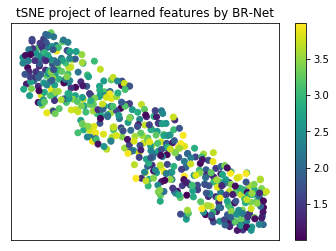

In [7]:
from sklearn.manifold import TSNE
tsne =  TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(feature_cf[-1])
plt.scatter(X_2d[:, 0], X_2d[:, 1],c=cf[y==0])
plt.title('tSNE project of learned features by BR-Net')

plt.xticks(np.arange(0), ())
plt.yticks(np.arange(0), ())
plt.colorbar()

plt.savefig('synthetic_tsne_brnet_cfeffect.pdf', format='pdf', dpi=300)